# **Setup**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. Dependencies Installieren

In [ ]:
%pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

2. Package importieren

In [3]:
#Packung für das Sammeln durch den Webcam
import os, time, uuid, cv2
from pathlib import Path

In [4]:
#Packung für Bilderverarbeitung
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [5]:
#Packung für die Ablumentation und die Bildung der Data-Pipeline
import albumentations as alb

In [6]:
#Packung für das Modelbau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [7]:
#Model Speicherung
from tensorflow.keras.models import load_model

# Bilder mit passenden Namen versehen (Umbenennung)

In [8]:
# Da ich mit Google Colab arbeiten, ist die Name meines Paths anderes bei euch. Allerdings ist dieser Teil nur für mich wichtig, deshalb musst ihr dieses Teil auch nicht activieren.
%cd "/content/drive/MyDrive/Programming/KIprojekt/BilderkennungAI"

/content/drive/MyDrive/Programming/KIprojekt/BilderkennungAI


In [ ]:
image_path = "data/test/images"

In [ ]:
%cd "/content/drive/MyDrive/Programming/KIprojekt/BilderkennungAI/{image_path}"

/content/drive/MyDrive/Programming/KIprojekt/BilderkennungAI/data/test/images


In [9]:
current_path = Path().resolve()
print(current_path)

/content/drive/MyDrive/Programming/KIprojekt/BilderkennungAI


In [ ]:
x = 1
for file in os.listdir():
  old_name = os.path.join(current_path, file)
  new_name = os.path.join(current_path,f"image{x}.jpg")
  os.rename(old_name, new_name)
  x+=1

In [10]:
%pwd

'/content/drive/MyDrive/Programming/KIprojekt/BilderkennungAI'

# Bilder labeln

In [ ]:
!labelme

Labelme öffnen, um Ausgangsdaten mit Labels zu versehen, dort wo Gesichter zu sehen sind (nach Akzepentanzkritierien PROJ-71)

Rechteck um das Gesicht, wenn kein Gesicht vorhanden Datei ignorieren

Labels als json in den labels Ordner übertragen

# **3. Die gesamte Datenmenge in kleineren Gruppen aufteilen**

Shuffling


In [ ]:
import random

In [ ]:
l = os.listdir(current_path)
random.shuffle(l)
print(l)

Trennung (Dieses Teil musst ihr nicht aktivieren)

In [ ]:
#training_set
for x in range(int(len(l)*0.7)+1):
  file = l[x]
  EX_PATH = os.path.join("data","images",file)
  NEW_PATH = os.path.join("data","train","images",file)
  os.replace(EX_PATH,NEW_PATH)

In [ ]:
#testing_set
for x in range(int(len(l)*0.5)):
  file = l[x]
  EX_PATH = os.path.join('data','images',file)
  NEW_PATH = os.path.join('data','test','images',file)
  os.replace(EX_PATH,NEW_PATH)
  

In [ ]:
#validation_set
for x in range(int(len(l)*0.5)):
  file = l[x]
  EX_PATH = os.path.join('data','test','images',file)
  NEW_PATH = os.path.join('data','val','images',file)
  os.replace(EX_PATH,NEW_PATH)

Die Labels auch trennen

In [ ]:
for folder in ['train','test','val']:
  for file in os.listdir(os.path.join('data',folder,'images')):
    filename = file.split('.')[0]+'.json'
    EX_PATH = os.path.join('data','labels',filename)
    if os.path.exists(EX_PATH):
      NEW_PATH = os.path.join('data',folder,'labels',filename)
      os.replace(EX_PATH,NEW_PATH)

# **4. Albumentation Setting für die Augmentatition den Bildern aufstellen**

In [70]:
augmentor = alb.Compose([alb.RandomCrop(width=200,height=300),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)], 
                        bbox_params= alb.BboxParams(format="albumentations",label_fields=["class_labels"]))

Laden eines Beispielbilds

In [108]:
img = cv2.imread(os.path.join('data','train','images','image88.jpg'))

In [109]:
size= img.shape
print(size)

(358, 236, 3)


In [110]:
with open(os.path.join('data','train','labels','image88.json'),'r') as f:
  label = json.load(f)

In [111]:
label['shapes'][0]['points']



[[100.43939393939394, 9.848484848484848],
 [138.6969696969697, 66.66666666666666]]

Koordinaten Extrahieren und Maßstab ändern

In [112]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]


In [113]:
coords

[100.43939393939394, 9.848484848484848, 138.6969696969697, 66.66666666666666]

In [114]:
coords = list(np.divide(coords,[size[1],size[0],size[1],size[0]]))

In [115]:
coords

[0.42559065228556753,
 0.027509734213644825,
 0.5876990241397021,
 0.18621973929236496]

Augmentation implimentieren

In [116]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [117]:
augmented['bboxes'][0][2:]


(0.5434848484848485, 1.0)

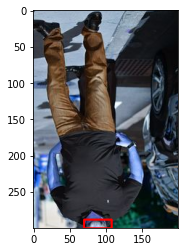

In [118]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [200,300]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [200,300]).astype(int)),
              (255,0,0),2)
plt.imshow(augmented['image'])

# **5. Augmentation Pipeline durchführen**

In [121]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

Expected y_max for bbox [0.440625, 0.048828125, 0.98505859375, 1.0026041666666667, 'face'] to be in the range [0.0, 1.0], got 1.0026041666666667.
Expected x_max for bbox [0.8048686594202898, 0.038194444444444434, 1.1298233695652173, 0.5665760869565217, 'face'] to be in the range [0.0, 1.0], got 1.1298233695652173.
Requested crop size (300, 200) is larger than the image size (225, 225)
Expected x_max for bbox [0.5689732142857142, 0.1744047619047619, 1.4444692460317459, 1.7220238095238094, 'face'] to be in the range [0.0, 1.0], got 1.4444692460317459.
Requested crop size (300, 200) is larger than the image size (231, 219)
Requested crop size (300, 200) is larger than the image size (259, 194)
Expected x_min for bbox [2.5991637323943664, 1.5266725352112678, 1.7140625, 0.0, 'face'] to be in the range [0.0, 1.0], got 2.5991637323943664.
y_max is less than or equal to y_min for bbox [0.12711943069306933, 0.1712046204620462, 0.17414913366336635, 0.0952970297029703, 'face'].
Expected y_min for